In [1]:
%matplotlib inline
import scipy.io as sio
from scipy.io import loadmat
from scipy.linalg import *
from scipy.optimize import linprog
from numpy import *
from math import sqrt
from time import time
from scipy.io import loadmat,savemat
from random import shuffle
import os,pickle,subprocess
from numpy.random import normal
import pandas as pd
from sklearn.tree import DecisionTreeClassifier, export_graphviz

In [3]:
from os import listdir
import matplotlib.pyplot as plt
from sklearn import tree
import csv
from sklearn.feature_selection import RFE

In [2]:
compliance =loadmat('compliance.mat')['compliance']
vf =loadmat('volumefraction.mat')['volumefraction']
constraints = sio.loadmat('constraints.mat')
stiffness = constraints['stiffness']

In [4]:
a = 3;
b = 20;
L = 0.45; # length of the beam

#I = (b*pow(a,3))/12; # moment of inertia in longitidunal direction


In [5]:
beta1 = 0.299;
beta2 = 0.312;
r1 = 6;
r2 = 10;
r = 6.67;
rat = (10-r)/(r-r1); 
beta = (beta2+(beta1*rat))/(rat+1);
J = beta*a*pow(b,3); # torsion constant for natural frequency

In [4]:
def loadData(name,path='.'):
    '''
    This loads a pickle file and returns the content which is a DICTIONARY object in our case.
    '''
    if ".pkl" in name:
            name = name.split(".pkl")[0]
    if "/" in name:
            name = name.split("/",1)[1]

    with open(path+"/"+name + '.pkl', 'rb') as f:
          return pickle.load(f)

def saveData(obj, name,path='.'):
    '''
    This saves a object into a pickle file. In our case, it is generally a DICTIONARY object.
    '''

    with open(path+"/"+name + '.pkl', 'wb') as f:
        pickle.dump(obj, f)

In [7]:
# Inertia moment computation
Iy = (a*pow(b,3))/12
Ix = (b*pow(a,3))/12
mass = 5# kg mass
Ip = Ix + Iy;  # Polar moment of inertia
A = a*b;  # Area of the rectangle cross-section
rhop = mass/(A*L);  # Mass per unit volume


# Bending Frequency Equations
alphaL = 1.87510;

In [8]:
Ix,Iy

(45, 2000)

In [9]:
def getBendingFreq(Ex):
    alphaSqr = pow(alphaL,2)
    sqrroot = sqrt((Ex*Ix)/(mass*pow(L,4)))
    w1b = (alphaSqr*sqrroot)/(2*pi)
    return w1b

def getTorsionalFreq(Gxy):
    piPart = (pi/(2*L))
    sqrroot = sqrt((Gxy*J)/(rhop*Ip))
    w1t = (piPart*sqrroot)/(2*pi)
    
    return w1t
    #w1t = ((pi/(2*L))*sqrt((Gxy*J)/(rhop*Ip)))/(2*pi);

def getw1b(Ex):
    return getBendingFreq(Ex)

def getw1t(Gxy):
    return getTorsionalFreq(Gxy)

In [10]:
def getFreqForOdfLower(odf):
    compliance_odf = compliance.dot(odf)
    S = compliance_odf.reshape(6,6); # Compliance matrix
    Ex = 1/S[0,0]; # Young's modulus
    Gxy= 1/S[5,5] # Shear modulus
    bendingFreq = getw1b(Ex)
    torsionalFreq = getw1t(Gxy)
    return bendingFreq,torsionalFreq

In [11]:
def getModulusLower(odf):
    compliance_odf = compliance.dot(odf)
    S = compliance_odf.reshape(6,6); # Compliance matrix
    Ex = 1/S[0,0]; # Young's modulus
    Gxy= 1/S[5,5] # Shear modulus
    return Ex,Gxy

def getModulusUpper(odf):
    constraints = sio.loadmat('constraints.mat')
    stiffness = constraints['stiffness']
    stiffness_avg = stiffness.dot(odf)
    stiffness_avg = stiffness_avg.reshape(6,6)
    S = inv(stiffness_avg)
    Ex = 1/S[0,0] 
    Gxy= 1/S[5,5]
    return Ex,Gxy

In [12]:
def getFreqForOdfUpper(odf):
    constraints = sio.loadmat('constraints.mat')
    stiffness = constraints['stiffness']
    stiffness_avg = stiffness.dot(odf)
    stiffness_avg = stiffness_avg.reshape(6,6)
    S = inv(stiffness_avg)
    Ex = 1/S[0,0] 
    Gxy= 1/S[5,5]
    bendingFreq = getw1b(Ex)
    torsionalFreq = getw1t(Gxy)
    return bendingFreq,torsionalFreq

In [13]:
def getStress(odf):
    f1=loadmat('linprog_a_yield.mat')['y']
    f1P = f1.conj().transpose()
    stress = f1P.dot(odf)[0]
    return stress

In [14]:
def isValidODF1Upper(odf):
    bendingFreq,torsionalFreq = getFreqForOdfUpper(odf)
    if bendingFreq >=120 and bendingFreq<=122.5 and torsionalFreq >=19.5 and torsionalFreq <=21.5:
        return True
    return False

def isValidODF2Upper(odf):
    bendingFreq,torsionalFreq = getFreqForOdfUpper(odf)
    if bendingFreq >=100 and bendingFreq<=114 and torsionalFreq >=21.5 and torsionalFreq <=23.5:
        return True
    return False

In [15]:
def isValidODF1Lower(odf):
    bendingFreq,torsionalFreq = getFreqForOdfLower(odf)
    if bendingFreq >=120 and bendingFreq<=122.5 and torsionalFreq >=19.5 and torsionalFreq <=21.5:
        return True
    return False

def isValidODF2Lower(odf):
    bendingFreq,torsionalFreq = getFreqForOdfLower(odf)
    if bendingFreq >=100 and bendingFreq<=114 and torsionalFreq >=21.5 and torsionalFreq <=23.5:
        return True
    return False
    

In [16]:
sample = loadmat('data_first5Generator_50.mat')
sample['t_Y_REk'][0][0]


1.5989230000000001

In [17]:
from numpy.random import permutation as randperm
from numpy.random import rand
from numpy import zeros,msort,array,diff,nonzero
from random import randint

In [18]:
def randSmallPartition(randsize):
    constraint = [0.0159822999947858,0.00818178632407973,0.00818178632407973,0.00818178632407973,0.00818178632407973,0.00818178632407973,0.00818178632407973,0.00613766636477021,0.00572645585112265,0.00572645585112265,0.00613766636477021,0.00572645585112265,0.00572645585112265,0.00572645585112265,0.00613766636477021,0.00572645585112265,0.00572645585112265,0.00572645585112265,0.00572645585112265,0.00572645585112265,0.00613766636477021,0.00572645585112265,0.00613766636477021,0.00572645585112265,0.00572645585112265,0.00572645585112265,0.00572645585112265,0.00572645585112265,0.00613766636477021,0.00613766636477021,0.00613766636477021,0.00376140480720866,0.00376140480720866,0.00376140480720866,0.00454084416782057,0.00454084416700527,0.00454084416700527,0.00454084416782057,0.00454084416782057,0.00454084416700527,0.00454084416782057,0.00454084416700527,0.00454084416700527,0.00454084416782057,0.00454084416700527,0.00454084416782057,0.00454084416782057,0.00454084416782057,0.00454084416782057,0.00454084416700527,0.00454084416700527,0.00454084416700527,0.00454084416700527,0.00454084416782057,0.00454084416700527,0.00454084416700527,0.00454084416782057,0.00454084416782057,0.00541192129558303,0.00495535011431222,0.00495535011431222,0.00541192129558303,0.00495535011431222,0.00541192129558303,0.00541192129558303,0.00541192129558303,0.00541192129558303,0.00541192129558303,0.00495535011431222,0.00541192129558303,0.00398197813454777,0.00398197813454777,0.00398197813454777,0.00398197813454777,0.00398197813454777,0.00398197813454777];
    fsize = 2; #fsize=num
    dsize = randsize;
    count = 0;
    all = 0;
    odfs = [];
    for j in range(dsize):
        cutsize =  fsize - 1;
        randSep = msort(rand(1,cutsize));
        randIntvl = array(diff([0,randSep,1],n=1,axis=0));

        randInd1 = randint(0,76)
        randInd2 = randint(0,76)
        x = [constraint[randInd1],constraint[randInd2]]
        print x
        #         divisor = array(constraint[randInd1],constraint[randInd2])
#         odf = zeros(1,76);
#         odf[randInd] = randIntvl/divisor;

#         [val,w1t,w1b] = SeparateOptimumYLower_1(odf);
#         all = all + 1;
#         if val == -10000:
#             count = count + 1;
#         else:
#             odfs += [(odf,-val)]

#     return odfs

In [19]:
def Plot(x,y,labelX="",labelY="",title=""):
    plt.plot(x,y)
    plt.xlabel(labelX)
    plt.ylabel(labelY)
    plt.title(title)
    
    

In [20]:
def getAverageFromOdfs(dfs,num,type="top"):
    Ods = dfs[:num]
    List = []
    for i in range(76):
        List += [0]
    
    for odf in Odfs:
        nz = nonzero(odf)[0].tolist()
        for elem in nz:
            List[elem] += 1
    average = []
    for i in indices:
        average += [float(List[i])/float(Odfs)]
    return average 

In [21]:
indices = list(range(76))

In [22]:
val = 385.2374

limit1 = val-(0.001*val)
limit2 = val-(0.005*val)
limit3 =  val-(0.0001*val)
limit4 =  val-(0.0002*val)


# Constraint 1 Upper Bound


In [23]:
rootdir = "data1_upper"
dictList,odf1,odf2,stress1,stress2 = [],[],[],[],[]
count,count1,count2 =0,0,0
countTotalUpper1 = 0
maxStress,maxBending,maxTorsional,maxOdf = 0,0,0,[]
dfs, bending,torsional,stress,filename = [],[],[],[],[]
for subdir, dirs, files in os.walk(rootdir):
    for file in files:
        countTotalUpper1 += int(file.split('_',2)[2].split('.mat')[0])
        odfs = loadmat(os.path.join(subdir, file))['odfs']
        for odf in odfs: 
            odf = odf[:76]
            if isValidODF1Upper(odf):
                dictionary = {}
                dictionary['odf'] = odf
                dictionary['bending'],dictionary['torsional'] = getFreqForOdfUpper(odf)
                dictionary['stress']= getStress(odf)
                
                dfs += [odf]
                bending += [dictionary['bending']]
                torsional += [dictionary['torsional']]
                stress += [dictionary['stress']]
                if 'Small' in file:
                    filename += [1]
                else:
                    filename += [0]
                    
#                 if dictionary['stress']>limit2:
#                     count2+= 1
#                     if dictionary['stress']>limit1:
#                         count1 += 1
#                         if dictionary['stress']>limit4:
#                             odf2 += [odf]
#                             stress2 += [stress]
#                             if dictionary['stress']>limit3:
#                                 odf1 += [odf]
#                                 stress1 += [stress]
                
                if dictionary['stress'] > maxStress:
                    maxStress = dictionary['stress']
                    maxBending,maxTorsional =  dictionary['bending'],dictionary['torsional']
                    maxOdf = odf 
                dictList += [dictionary]
            else:
                count += 1

# combined = zip(stress,dfs,bending,torsional)
# combined = sorted(combined, key=lambda i: int(i[0]), reverse=True)
# stress[:],dfs[:],bending[:],torsional[:] = zip(*combined)

In [24]:
getModulusUpper(maxOdf),maxBending,maxTorsional,maxStress

((209.54606664864474, 77.31332162676749),
 120.00655895243895,
 21.341344070451925,
 385.23742285360208)

In [25]:
combined = zip(stress,dfs,bending,torsional)
combined = sorted(combined, key=lambda i: int(i[0]), reverse=True)
stress[:],dfs[:],bending[:],torsional[:] = zip(*combined)

In [1]:
a = {[1,1,1]:(1,2),[1,2,3]:(2,3)}
a.keys()

TypeError: unhashable type: 'list'

In [26]:
countTotalUpper1

24403200

In [27]:
maxOdf

array([   0.        ,    0.        ,    0.        ,    0.        ,
          0.        ,    0.        ,    0.        ,    0.        ,
          0.        ,    0.        ,    0.        ,    0.        ,
          0.        ,    0.        ,    0.        ,    0.        ,
          0.        ,    0.        ,    0.        ,    0.        ,
          0.        ,    0.        ,    0.        ,    0.        ,
          0.        ,    0.        ,    0.        ,    0.        ,
          0.        ,    0.        ,    0.        ,    0.        ,
          0.        ,    0.        ,    0.        ,    0.        ,
          0.        ,    0.        ,    0.        ,    0.        ,
          0.        ,    0.        ,    0.        ,    0.        ,
          0.        ,    0.        ,    0.        ,    0.        ,
          0.        ,    0.        ,   83.65844314,    0.        ,
          0.        ,    0.        ,    0.        ,    0.        ,
          0.        ,    0.        ,    0.        ,    0.     

In [28]:
maxStress


385.23742285360208

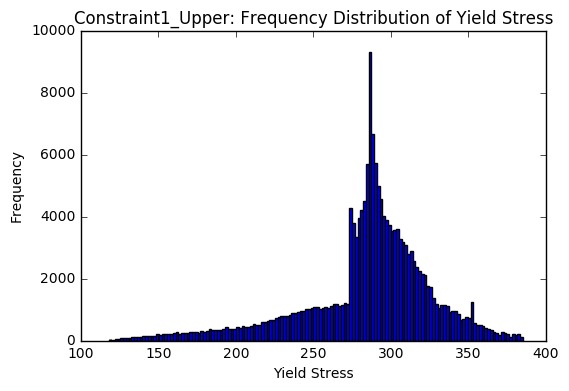

In [81]:
plt.hist(stress,bins=150)
plt.title("Constraint1_Upper: Frequency Distribution of Yield Stress")
plt.xlabel("Yield Stress")
plt.ylabel("Frequency")
plt.show()

In [30]:
count1,count2

(0, 0)

In [31]:
print len(odf1),len(odf2)

0 0


In [32]:
maxOdfMat,topOdfs = {},{}
maxOdfMat['odf']= maxOdf
savemat('maxOdf.mat',maxOdfMat)

In [33]:
topodfs= []
for odf in odf1:
    topodfs += [odf]
topOdfs['odf']= topodfs
savemat('otherOdfs_Higher1.mat',topOdfs)

In [34]:
for i in range(len(odf2)-1):
    for j in range(i+1,len(odf2)):
        odf= odf2[i]
        odfC = odf2[j]
        if set(odf)&set(odfC)!=None:
            pass
    

In [26]:
List = []
for i in range(76):
    List += [0]
for odf in dfs:
    nz = nonzero(odf)[0].tolist()
    for elem in nz:
        List[elem] += 1

average = []
for i in indices:
    average += [float(List[i])/float(len(dfs))]

In [28]:
topValDict = {}
topValDict['freq'] = topList
savemat('constraint1UpperTop.mat',topValDict)

In [35]:
List1,List2 = [],[]
for i in range(76):
    List1 += [0]
    List2 += [0]
for i in range(len(dfs)):
    odf = dfs[i]
    nz = nonzero(odf)[0].tolist()
    if filename[i] == 1:
        for elem in nz:
            List1[elem] += 1
    else:
        for elem in nz:
            List2[elem] += 1
            

average1,average2 = [],[]
for i in indices:
    average1 += [float(List1[i])/float(len(dfs))]
    
for i in indices:
    average2 += [float(List2[i])/float(len(dfs))]

In [27]:
topOdfs = dfs[:5000]
topList = []
for i in range(76):
    topList += [0]
    
for odf in topOdfs:
    nz = nonzero(odf)[0].tolist()
    for elem in nz:
        topList[elem] += 1

topAverage = []
for i in indices:
    topAverage += [float(topList[i])/float(len(topOdfs))]

In [37]:
bottomOdfs = dfs[-5000:]
bottomList = []
for i in range(76):
    bottomList += [0]
    
for odf in bottomOdfs:
    nz = nonzero(odf)[0].tolist()
    for elem in nz:
        bottomList[elem] += 1

bottomAverage = []
for i in indices:
    bottomAverage += [float(bottomList[i])/float(len(bottomOdfs))]

In [38]:
maxStress

385.23742285360208

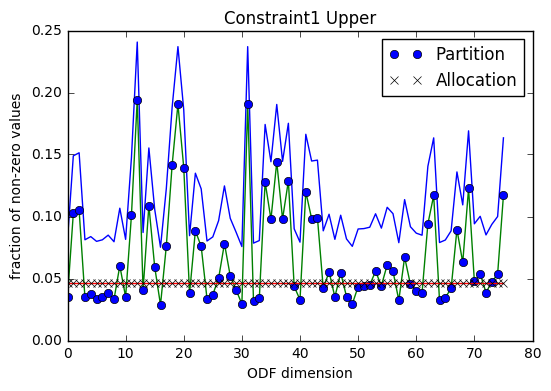

In [46]:
Plot(indices, average,"ODF dimension","fraction of non-zero values","Constraint1 Upper")
plt.xlabel("ODF dimension")
plt.ylabel("fraction of non-zero values")
plt.title("Constraint1 Upper")
#attributes = [1851,1651,1451,1251,1051,851,651,451,251,51]
attributes = list(range(21))
l1, = plt.plot(indices, average1)
l2, = plt.plot(indices, average1,'o',color='b',label="Partition")
l3, = plt.plot(indices, average2)
l4, = plt.plot(indices, average2,'x',color='k',label="Allocation")

plt.legend(loc='upper right')
# plt.axis([0,23, 0.55, 0.9])

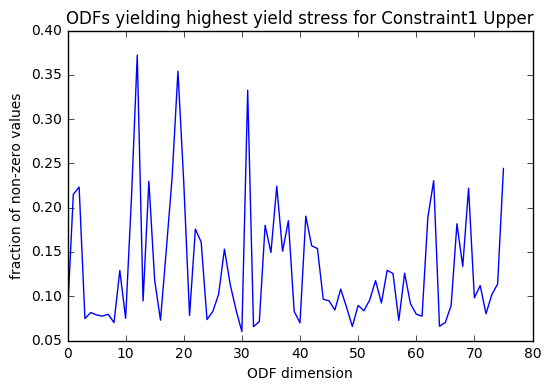

In [47]:
Plot(indices, topAverage,"ODF dimension","fraction of non-zero values","ODFs yielding highest yield stress for Constraint1 Upper")

In [48]:
for i in indices:
    if topAverage[i]>0.15:
        print i

1
2
11
12
14
17
18
19
20
22
23
27
31
34
36
37
38
41
42
43
62
63
67
69
75


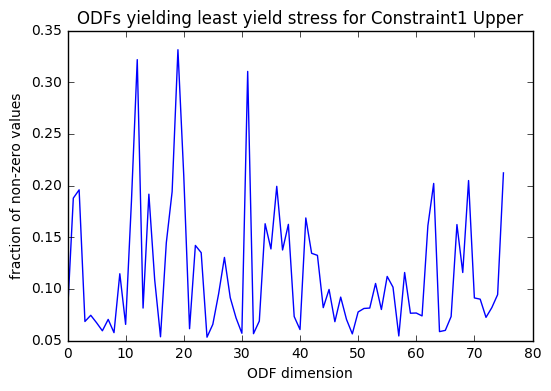

In [49]:
Plot(indices, bottomAverage,"ODF dimension","fraction of non-zero values","ODFs yielding least yield stress for Constraint1 Upper")

# Constraint 1 Lower Bound


In [29]:
val= 385.113
limit1 = val -(0.001*val)
limit2 = val -(0.005*val)
# limit3 = val -(0.0001*val)
limit4 = val -(0.0005*val)

In [30]:
rootdir = "data1_lower"
dictList,odf1,odf2,stress1,stress2 = [],[],[],[],[]
count =0
countTotalLower = 0
count1,count2=0,0
maxStress,maxBending,maxTorsional,maxOdf = 0,0,0,[]
dfs, bending,torsional,stress = [],[],[],[]
for subdir, dirs, files in os.walk(rootdir):
    for file in files:
        countTotalLower += int(file.split('_',2)[2].split('.mat')[0])
        odfs = loadmat(os.path.join(subdir, file))['odfs']
        for odf in odfs: 
            odf = odf[:76]
            if isValidODF1Lower(odf):
                dictionary = {}
                dictionary['odf'] = odf
                dictionary['bending'],dictionary['torsional'] = getFreqForOdfLower(odf)
                dictionary['stress']= getStress(odf)
                
                dfs += [odf]
                bending += [dictionary['bending']]
                torsional += [dictionary['torsional']]
                stress += [dictionary['stress']]
                
#                 if dictionary['stress']>limit2:
#                     count2+= 1
#                     if dictionary['stress']>limit1:
#                         count1 += 1
#                         odf1 += [odf]
#                         stress1 += [stress]
#                         if dictionary['stress']>limit4:
#                             odf2 += [odf]
#                             stress2 += [stress]
                           
                        
                if dictionary['stress'] > maxStress:
                    maxStress = dictionary['stress']
                    maxBending,maxTorsional =  dictionary['bending'],dictionary['torsional']
                    maxOdf = odf 
                dictList += [dictionary]
            else:
                count += 1


In [31]:
getModulusLower(maxOdf),maxBending,maxTorsional,maxStress

((213.98802771272105, 77.329996822463741),
 121.27183929024118,
 21.343645432587913,
 385.11315910404392)

In [53]:
count1,count2

(0, 0)

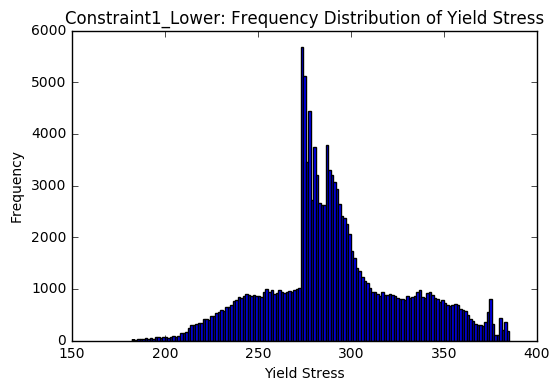

In [54]:
plt.hist(stress,bins=150)
plt.title("Constraint1_Lower: Frequency Distribution of Yield Stress")
plt.xlabel("Yield Stress")
plt.ylabel("Frequency")
plt.show()

In [55]:
saveData(maxOdf,'odfBestLower_1','.')

In [56]:
len(odf1),len(odf2)

(0, 0)

In [57]:
maxOdfMat,topOdfs = {},{}
maxOdfMat['odf']= maxOdf
savemat('maxOdf_Lower1.mat',maxOdfMat)

In [58]:
topodfs= []
for odf in odf1:
    topodfs += [odf]
topOdfs['odf']= topodfs
savemat('otherOdfs_Lower1.mat',topOdfs)

In [59]:
topOdfs = {}
topodfs= []
for odf in odf2:
    topodfs += [odf]
topOdfs['odf']= topodfs
savemat('topOdfs_Lower1.mat',topOdfs)

In [32]:
combined = zip(stress,dfs,bending,torsional)
combined = sorted(combined, key=lambda i: int(i[0]), reverse=True)
stress[:],dfs[:],bending[:],torsional[:] = zip(*combined)

In [33]:
List = []
for i in range(76):
    List += [0]
for odf in dfs:
    nz = nonzero(odf)[0].tolist()
    for elem in nz:
        List[elem] += 1

average = []
for i in indices:
    average += [float(List[i])/float(len(dfs))]

In [34]:
topOdfs = dfs[:5000]
topList = []
for i in range(76):
    topList += [0]
    
for odf in topOdfs:
    nz = nonzero(odf)[0].tolist()
    for elem in nz:
        topList[elem] += 1

topAverage = []
for i in indices:
    topAverage += [float(topList[i])/float(len(topOdfs))]

In [35]:
topValDict = {}
topValDict['freq'] = topList
savemat('constraint1LowerTop.mat',topValDict)

In [63]:
bottomOdfs = dfs[-5000:]
bottomList = []
for i in range(76):
    bottomList += [0]
    
for odf in bottomOdfs:
    nz = nonzero(odf)[0].tolist()
    for elem in nz:
        bottomList[elem] += 1

bottomAverage = []
for i in indices:
    bottomAverage += [float(bottomList[i])/float(len(bottomOdfs))]

### Odf dimensions which produces the highest stress values (top 5000)


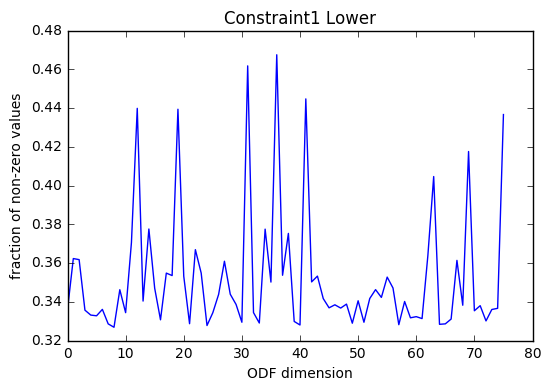

In [64]:
Plot(indices, average,"ODF dimension","fraction of non-zero values","Constraint1 Lower")

### Odf dimensions which produces the highest stress values (top 5000)


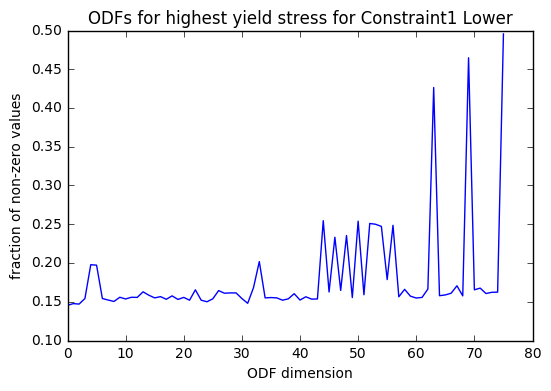

In [65]:
Plot(indices, topAverage,"ODF dimension","fraction of non-zero values","ODFs for highest yield stress for Constraint1 Lower")

In [66]:
topAverage

[0.1454,
 0.1476,
 0.147,
 0.1542,
 0.1978,
 0.1972,
 0.1542,
 0.1522,
 0.1504,
 0.1558,
 0.1536,
 0.1558,
 0.1556,
 0.1628,
 0.1584,
 0.155,
 0.1566,
 0.1532,
 0.1576,
 0.153,
 0.1556,
 0.152,
 0.1654,
 0.152,
 0.15,
 0.1538,
 0.1644,
 0.161,
 0.1614,
 0.1614,
 0.1542,
 0.148,
 0.1682,
 0.2018,
 0.155,
 0.1554,
 0.155,
 0.152,
 0.1538,
 0.1604,
 0.1522,
 0.1564,
 0.1534,
 0.1536,
 0.2546,
 0.1626,
 0.2332,
 0.1646,
 0.2354,
 0.1554,
 0.254,
 0.159,
 0.251,
 0.25,
 0.2472,
 0.1786,
 0.2486,
 0.1564,
 0.166,
 0.1572,
 0.1548,
 0.1556,
 0.1664,
 0.4264,
 0.1578,
 0.1588,
 0.161,
 0.1706,
 0.1576,
 0.4648,
 0.1654,
 0.1676,
 0.1606,
 0.1622,
 0.1624,
 0.4956]

In [67]:
for i in indices:
    if topAverage[i]>0.25:
        print i

44
50
52
63
69
75


In [71]:
len(topAverage)

76

### Odf dimensions which produces the highest stress values (bottom 5000)

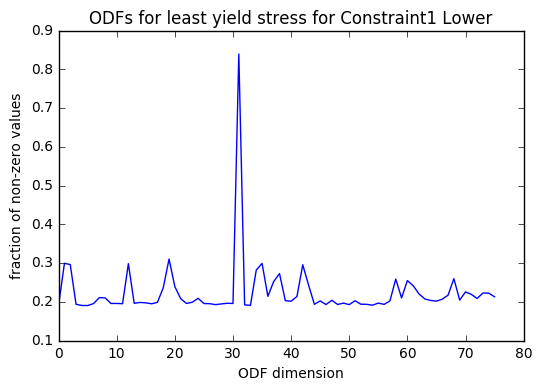

In [68]:
Plot(indices, bottomAverage,"ODF dimension","fraction of non-zero values","ODFs for least yield stress for Constraint1 Lower")

# Constraint 2 Upper Bound

In [36]:
val = 388.09234403536925
limit1 = val -(0.001*val)
limit2 = val -(0.005*val)
limit3 = val -(0.0001*val)
limit4 = val -(0.0002*val)

In [37]:
rootdir = "data2_upper_1"
dictList,odf1,odf2,stress1,stress2 = [],[],[],[],[]
count,countTotal = 0,0
count1,count2=0,0
Odfs = []
dfs, bending,torsional,stress = [],[],[],[]
maxStress,maxBending,maxTorsional,maxOdf = 0,0,0,[]
for subdir, dirs, files in os.walk(rootdir):
    for file in files:
        countTotal += int(file.split('_',2)[2].split('.mat')[0])
        odfs = loadmat(os.path.join(subdir, file))['odfs']
        for odf in odfs: 
            odf = odf[:76]
            if isValidODF2Upper(odf):
                Odfs += [odf]
                dictionary = {}
                dictionary['odf'] = odf
                dictionary['bending'],dictionary['torsional'] = getFreqForOdfUpper(odf)
                dictionary['stress']= getStress(odf)
                
                dfs += [odf]
                bending += [dictionary['bending']]
                torsional += [dictionary['torsional']]
                stress += [dictionary['stress']]
                
#                 if dictionary['stress']>limit2:
#                     count2+= 1
#                     if dictionary['stress']>limit1:
#                         count1 += 1
#                         if dictionary['stress']>limit4:
#                             odf2 += [odf]
#                             stress2 += [stress]
#                             if dictionary['stress']>limit3:
#                                 odf1 += [odf]
#                                 stress1 += [stress]
                
                if dictionary['stress'] > maxStress:
                    maxStress = dictionary['stress']
                    maxBending,maxTorsional =  dictionary['bending'],dictionary['torsional']
                    maxOdf = odf 
                dictList += [dictionary]
            else:
                count += 1
                


In [126]:
dfs

[]

In [122]:
rootdir = "data2_upper_2"
dictList = []
count = 0
Odfs = []
dfs, bending,torsional,stress = [],[],[],[]
for subdir, dirs, files in os.walk(rootdir):
    for file in files:
        odfs = loadmat(os.path.join(subdir, file))['odfs']
        for odf in odfs: 
            odf = odf[:76]
            if isValidODF2Upper(odf):
                Odfs += [odf]
                dictionary = {}
                dictionary['odf'] = odf
                dictionary['bending'],dictionary['torsional'] = getFreqForOdfUpper(odf)
                dictionary['stress']= getStress(odf)
                
                dfs += [odf]
                bending += [dictionary['bending']]
                torsional += [dictionary['torsional']]
                stress += [dictionary['stress']]
                
#                 if dictionary['stress']>limit2:
#                     count2+= 1
#                     if dictionary['stress']>limit1:
#                         count1 += 1
#                         if dictionary['stress']>limit4:
#                             odf2 += [odf]
#                             stress2 += [stress]
#                             if dictionary['stress']>limit3:
#                                 odf1 += [odf]
#                                 stress1 += [stress]
                
                if dictionary['stress'] > maxStress:
                    maxStress = dictionary['stress']
                    maxBending,maxTorsional =  dictionary['bending'],dictionary['torsional']
                    maxOdf = odf 
                dictList += [dictionary]
            else:
                count += 1

ValueError: Not enough bytes to read matrix '%                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                 @      �                                        @      �                                          @      �                                          @                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                   E'; is this a badly-formed file? Consider listing matrices with `whosmat` and loading named matrices with `variable_names` kwarg to `loadmat`

In [ ]:
maxOdf = loadmat('upper_2/maxOdf_Upper2.mat')['odf']
Ex,Gxy = getModulusUpper(maxOdf.transpose())
w1b = getw1b(Ex)
w1t = getw1t(Gxy)
stress = getStress(odf)
stress,Ex,Gxy,w1b,w1t

In [ ]:
getModulusUpper(maxOdf),maxBending,maxTorsional,maxStress

In [ ]:
maxOdfMat,topOdfs = {},{}
maxOdfMat['odf']= maxOdf
savemat('maxOdf_Lower1.mat',maxOdfMat)

In [ ]:
topodfs= []
for odf in odf1:
    topodfs += [odf]
topOdfs['odf']= topodfs
savemat('topOdfs_Lower1.mat',topOdfs)

In [ ]:
len(odf1),len(odf2)

In [ ]:
plt.hist(stress,bins=150)
plt.title("Constraint2_Upper: Frequency Distribution of Yield Stress")
plt.xlabel("Yield Stress")
plt.ylabel("Frequency")
plt.show()

In [38]:
combined = zip(stress,dfs,bending,torsional)
combined = sorted(combined, key=lambda i: int(i[0]), reverse=True)
stress[:],dfs[:],bending[:],torsional[:] = zip(*combined)

In [129]:
List = []
for i in range(76):
    List += [0]
for odf in dfs:
    nz = nonzero(odf)[0].tolist()
    for elem in nz:
        List[elem] += 1

average = []
for i in indices:
    average += [float(List[i])/float(len(Odfs))]

In [39]:
topOdfs = dfs[:5000]
topList = []
for i in range(76):
    topList += [0]
    
for odf in topOdfs:
    nz = nonzero(odf)[0].tolist()
    for elem in nz:
        topList[elem] += 1

topAverage = []
for i in indices:
    topAverage += [float(topList[i])/float(len(topOdfs))]

In [132]:
topValDict = {}
topValDict['freq'] = topList
savemat('constraint2UpperTop.mat',topValDict)

In [ ]:
bottomOdfs = dfs[-5000:]
bottomList = []
for i in range(76):
    bottomList += [0]
    
for odf in bottomOdfs:
    nz = nonzero(odf)[0].tolist()
    for elem in nz:
        bottomList[elem] += 1

bottomAverage = []
for i in indices:
    bottomAverage += [float(bottomList[i])/float(len(bottomOdfs))]

In [ ]:
minval = 10000
maxval = 0
fd = []
for i in [33,44,50,63,69,75]:
    fdi = []
    for df in dfs:
        
        if df[i]<minval:
            minval = df[i]
        if df[i]>maxval:
            maxval = df[i]
        fdi += [df[i]]
    fd += [fdi]
    
            

In [ ]:
len(fd[0])

In [ ]:
plt.plot(indices, average)

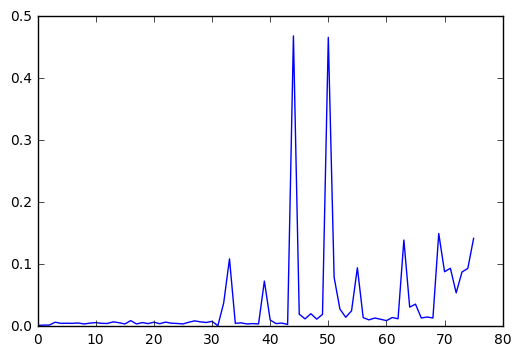

In [40]:
plt.plot(indices, topAverage)

In [ ]:
for i in indices:
    if topAverage[i]>0.055:
        print i

In [ ]:
plt.plot(indices, bottomAverage)

# Constraint 2 Lower Bound

In [133]:
val = 387.078
# limit1 = 0.999*val
# limit2= 0.995 *val
limit1 = val -(0.001*val)
limit2 = val -(0.005*val)
limit3 = val -(0.0001*val)
limit4 = val -(0.0005*val)

In [134]:
rootdir = "data2_lower"
dictList,odf2,odf1 = [],[],[]
count,count1,count2 = 0,0,0
countTotal = 0
Odfs = []
dfs, bending,torsional,stress = [],[],[],[]
maxStress,maxBending,maxTorsional,maxOdf = 0,0,0,[]
for subdir, dirs, files in os.walk(rootdir):
    for file in files:
        countTotal += int(file.split('_',2)[2].split('.mat')[0])
        odfs = loadmat(os.path.join(subdir, file))['odfs']
        for odf in odfs: 
            odf = odf[:76]
            if isValidODF2Lower(odf):
                Odfs += [odf]
                dictionary = {}
                dictionary['odf'] = odf
                dictionary['bending'],dictionary['torsional'] = getFreqForOdfLower(odf)
                dictionary['stress']= getStress(odf)
                
                dfs += [odf]
                bending += [dictionary['bending']]
                torsional += [dictionary['torsional']]
                stress += [dictionary['stress']]
                
                if dictionary['stress']>limit2:
                    count2+= 1
                    if dictionary['stress']>limit1:
                        count1 += 1
                        if dictionary['stress']>limit4:
                            odf2 += [odf]
                            stress2 += [stress]
                            if dictionary['stress']>limit3:
                                odf1 += [odf]
                                stress1 += [stress]
                
                if dictionary['stress'] > maxStress:
                    maxStress = dictionary['stress']
                    maxBending,maxTorsional =  dictionary['bending'],dictionary['torsional']
                    maxOdf = odf 
                dictList += [dictionary]
            else:
                count += 1

In [ ]:
maxStress

In [ ]:
maxOdfMat,topOdfs = {},{}
maxOdfMat['odf']= maxOdf
savemat('maxOdf_Lower2.mat',maxOdfMat)

In [9]:
x = loadmat('data_pinar/maxOdf_Lower1.mat')

In [12]:
y = loadmat('lower_1/topOdfs_Lower1.mat')

In [16]:
from collections import Counter

In [21]:
y['odf']

array([[   0.        ,    0.        ,    0.        ,    0.        ,
           0.        ,    0.        ,    0.        ,    0.        ,
           0.        ,    0.        ,    0.        ,    0.        ,
           0.        ,    0.        ,    0.        ,    0.        ,
           0.        ,    0.        ,    0.        ,    0.        ,
           0.        ,    0.        ,    0.        ,    0.        ,
           0.        ,    0.        ,    0.        ,    0.        ,
           0.        ,    0.        ,    0.        ,    0.        ,
           0.        ,    0.        ,    0.        ,    0.        ,
           0.        ,    0.        ,    0.        ,    0.        ,
           0.        ,    0.        ,    0.        ,    0.        ,
          55.8860106 ,    0.        ,    0.        ,    0.        ,
           0.        ,    0.        ,    0.        ,   19.37824956,
           0.        ,    0.        ,    0.        ,    0.        ,
           0.        ,    0.        ,    0.     

In [20]:
Counter(y['odf'][0])

Counter({0.0: 73,
         19.378249563008762: 1,
         55.886010596910587: 1,
         165.30395221359458: 1})

In [22]:
for i in range(len(y['odf'])):
    

array([[   0.        ,    0.        ,    0.        ,    0.        ,
           0.        ,    0.        ,    0.        ,    0.        ,
           0.        ,    0.        ,    0.        ,    0.        ,
           0.        ,    0.        ,    0.        ,    0.        ,
           0.        ,    0.        ,    0.        ,    0.        ,
           0.        ,    0.        ,    0.        ,    0.        ,
           0.        ,    0.        ,    0.        ,    0.        ,
           0.        ,    0.        ,    0.        ,    0.        ,
           0.        ,    0.        ,    0.        ,    0.        ,
           0.        ,    0.        ,    0.        ,    0.        ,
           0.        ,    0.        ,    0.        ,    0.        ,
          55.8860106 ,    0.        ,    0.        ,    0.        ,
           0.        ,    0.        ,    0.        ,   19.37824956,
           0.        ,    0.        ,    0.        ,    0.        ,
           0.        ,    0.        ,    0.     

In [ ]:
topOdfs = {}
topodfs= []
for odf in odf1:
    topodfs += [odf]
topOdfs['odf']= topodfs
savemat('topOdfs_Lower2.mat',topOdfs)

In [ ]:
topOdfs = {}
topodfs= []
for odf in odf2:
    topodfs += [odf]
topOdfs['odf']= topodfs
savemat('otherOdfs_Lower2.mat',topOdfs)

In [ ]:
saveData(maxOdf,'odfBestLower_2')

In [135]:
combined = zip(stress,dfs,bending,torsional)
combined = sorted(combined, key=lambda i: int(i[0]), reverse=True)
stress[:],dfs[:],bending[:],torsional[:] = zip(*combined)

In [ ]:
List = []
for i in range(76):
    List += [0]

In [ ]:
x = []
for odf in Odfs:
    nz = nonzero(odf)[0].tolist()
    for elem in nz:
        List[elem] += 1
    

In [ ]:
average = []
for i in indices:
    average += [float(List[i])/float(len(Odfs))]

In [136]:
topOdfs = dfs[:5000]
topList = []
for i in range(76):
    topList += [0]
    
for odf in topOdfs:
    nz = nonzero(odf)[0].tolist()
    for elem in nz:
        topList[elem] += 1

topAverage = []
for i in indices:
    topAverage += [float(topList[i])/float(len(topOdfs))]

In [137]:
topValDict = {}
topValDict['freq'] = topList
savemat('constraint2LowerTop.mat',topValDict)

In [ ]:
bottomOdfs = dfs[-5000:]
bottomList = []
for i in range(76):
    bottomList += [0]
    
for odf in bottomOdfs:
    nz = nonzero(odf)[0].tolist()
    for elem in nz:
        bottomList[elem] += 1

bottomAverage = []
for i in indices:
    bottomAverage += [float(bottomList[i])/float(len(bottomOdfs))]

### Odf dimensions for the sampled values (noteworthy: none of them is zero)


In [ ]:
Plot(indices, average,"ODF dimension","fraction of non-zero values","Constraint2 Lower")

### Odf dimensions which produces the least stress values (top 2000)


In [ ]:
Plot(indices, topAverage)

In [ ]:
for i in indices:
    if topAverage[i]>0.25:
        print i

### Odf dimensions which produces the highest stress values (top 5000)


In [ ]:
minval = 10000
maxval = 0
for i in [33,44,50,63,69,75]:
    for df in dfs:
        
        if df[i]<minval:
            minval = df[i]
        if df[i]>maxval:
            maxval = df[i]
        
        
    plt.hist(stress,bins=150)
    plt.title("Constraint2_Lower: Frequency Distribution of Yield Stress")
    plt.xlabel("Yield Stress")
    plt.ylabel("Frequency")
    plt.show()
    print i,minval,maxval
            
    

In [ ]:
bottomLabels,topLabels = [-1]*5000,[1]*5000


In [ ]:

plt.hist(stress,bins=150)
plt.title("Constraint2_Lower: Frequency Distribution of Yield Stress")
plt.xlabel("Yield Stress")
plt.ylabel("Frequency")
plt.show()

In [ ]:
Plot(indices, topAverage,"ODF dimension","fraction of non-zero values","ODFs for highest yield stress for Constraint2 Lower")

### Odf dimensions which produces the least stress values (bottom 5000)

In [ ]:
Plot(indices, bottomAverage,"ODF dimension","fraction of non-zero values","ODFs for least yield stress for Constraint2 Lower")

In [ ]:
def get_iris_data():
    """Get the iris data, from local csv or pandas repo."""
    if os.path.exists("iris.csv"):
        print("-- iris.csv found locally")
        df = pd.read_csv("iris.csv", index_col=0)
    else:
        print("-- trying to download from github")
        fn = "https://raw.githubusercontent.com/pydata/pandas/" + \
             "master/pandas/tests/data/iris.csv"
        try:
            df = pd.read_csv(fn)
        except:
            exit("-- Unable to download iris.csv")

        with open("iris.csv", 'w') as f:
            print("-- writing to local iris.csv file")
            df.to_csv(f)

    return df

In [ ]:
df = get_iris_data()

In [ ]:
print "* df.head()", df.head()
print "* df.tail()", df.tail()

In [ ]:
def encode_target(df, target_column):
    """Add column to df with integers for the target.

    Args
    ----
    df -- pandas DataFrame.
    target_column -- column to map to int, producing
                     new Target column.

    Returns
    -------
    df_mod -- modified DataFrame.
    targets -- list of target names.
    """
    df_mod = df.copy()
    targets = df_mod[target_column].unique()
    map_to_int = {name: n for n, name in enumerate(targets)}
    df_mod["Target"] = df_mod[target_column].replace(map_to_int)

    return (df_mod, targets)

In [ ]:
df2, targets = encode_target(df, "Name")
print "* df2.head()", df2[["Target", "Name"]].head()
print "* df2.tail()", df2[["Target", "Name"]].tail()
print "* targets", targets
features = list(df2.columns[:4])

In [ ]:
y = df2["Target"]
X = df2[features]
dt = DecisionTreeClassifier(min_samples_split=20, random_state=99)
dt.fit(X, y)

In [ ]:
def visualize_tree(tree, feature_names):
    """Create tree png using graphviz.

    Args
    ----
    tree -- scikit-learn DecsisionTree.
    feature_names -- list of feature names.
    """
    with open("dt.dot", 'w') as f:
        export_graphviz(tree, out_file=f,
                        feature_names=feature_names)

    command = ["dot", "-Tpng", "dt.dot", "-o", "dt.png"]
    try:
        subprocess.check_call(command)
        print 'here'
    except:
        exit("Could not run dot, ie graphviz, to "
             "produce visualization")

In [ ]:
visualize_tree(dt, features)

### Sample for data1 upper

In [ ]:
file = "data1_upper/data_SmallPartition2_1000000.mat"
dictList,odf1,odf2 = [],[],[]
count =0
countTotalLower = 0
count1,count2=0,0
maxStress,maxBending,maxTorsional,maxOdf = 0,0,0,[]
dfs, bending,torsional,stress = [],[],[],[]
# countTotalLower += int(file.split('_',2)[2].split('.mat')[0])
odfs = loadmat(file)['odfs']
for odf in odfs: 
    odf = odf[:76]
    if isValidODF1Upper(odf):
        dictionary = {}
        dictionary['odf'] = odf
        dictionary['bending'],dictionary['torsional'] = getFreqForOdfUpper(odf)
        dictionary['stress']= getStress(odf)

        dfs += [odf]
        bending += [dictionary['bending']]
        torsional += [dictionary['torsional']]
        stress += [dictionary['stress']]

#         if dictionary['stress']>limit2:
#             count2+= 1
#             if dictionary['stress']>limit1:
#                 count1 += 1
#                 odf1 += [odf]
#                 stress1 += [stress]
#                 if dictionary['stress']>limit4:
#                     odf2 += [odf]
#                     stress2 += [stress]


        if dictionary['stress'] > maxStress:
            maxStress = dictionary['stress']
            maxBending,maxTorsional =  dictionary['bending'],dictionary['torsional']
            maxOdf = odf 
        dictList += [dictionary]
    else:
        count += 1

In [ ]:
maxStress

In [ ]:
combined = zip(stress,dfs,bending,torsional)
combined = sorted(combined, key=lambda i: int(i[0]), reverse=True)
stress[:],dfs[:],bending[:],torsional[:] = zip(*combined)
topOdfs = dfs[:2000]
topList = []
for i in range(76):
    topList += [0]
    
for odf in topOdfs:
    nz = nonzero(odf)[0].tolist()
    for elem in nz:
        topList[elem] += 1

topAverage = []
for i in indices:
    topAverage += [float(topList[i])/float(len(topOdfs))]
    
bottomOdfs = dfs[-2000:]
bottomList = []
for i in range(76):
    bottomList += [0]
    
for odf in bottomOdfs:
    nz = nonzero(odf)[0].tolist()
    for elem in nz:
        bottomList[elem] += 1

bottomAverage = []
for i in indices:
    bottomAverage += [float(bottomList[i])/float(len(bottomOdfs))]

In [ ]:
Plot(indices, topAverage,"ODF dimension","fraction of non-zero values","ODFs for highest yield stress for Constraint1 Lower")

In [ ]:
for i in indices:
    if topAverage[i]>0.08:
        print i

In [ ]:
file = "data1_lower/data_SmallPartition2_1000000.mat"
dictList,odf1,odf2 = [],[],[]
count =0
countTotalLower = 0
count1,count2=0,0
maxStress,maxBending,maxTorsional,maxOdf = 0,0,0,[]
dfs, bending,torsional,stress = [],[],[],[]
# countTotalLower += int(file.split('_',2)[2].split('.mat')[0])
odfs = loadmat(file)['odfs']
for odf in odfs: 
    odf = odf[:76]
    if isValidODF1Lower(odf):
        dictionary = {}
        dictionary['odf'] = odf
        dictionary['bending'],dictionary['torsional'] = getFreqForOdfLower(odf)
        dictionary['stress']= getStress(odf)

        dfs += [odf]
        bending += [dictionary['bending']]
        torsional += [dictionary['torsional']]
        stress += [dictionary['stress']]

#         if dictionary['stress']>limit2:
#             count2+= 1
#             if dictionary['stress']>limit1:
#                 count1 += 1
#                 odf1 += [odf]
#                 stress1 += [stress]
#                 if dictionary['stress']>limit4:
#                     odf2 += [odf]
#                     stress2 += [stress]


        if dictionary['stress'] > maxStress:
            maxStress = dictionary['stress']
            maxBending,maxTorsional =  dictionary['bending'],dictionary['torsional']
            maxOdf = odf 
        dictList += [dictionary]
    else:
        count += 1

In [ ]:
combined = zip(stress,dfs,bending,torsional)
combined = sorted(combined, key=lambda i: int(i[0]), reverse=True)
stress[:],dfs[:],bending[:],torsional[:] = zip(*combined)
    
topOdfs = dfs[:2000]
topList = []
for i in range(76):
    topList += [0]
    
for odf in topOdfs:
    nz = nonzero(odf)[0].tolist()
    for elem in nz:
        topList[elem] += 1

topAverage = []
for i in indices:
    topAverage += [float(topList[i])/float(len(topOdfs))]
    
bottomOdfs = dfs[-2000:]
bottomList = []
for i in range(76):
    bottomList += [0]
    
for odf in bottomOdfs:
    nz = nonzero(odf)[0].tolist()
    for elem in nz:
        bottomList[elem] += 1

bottomAverage = []
for i in indices:
    bottomAverage += [float(bottomList[i])/float(len(bottomOdfs))]

In [ ]:
Plot(indices, topAverage,"ODF dimension","fraction of non-zero values","ODFs for highest yield stress for Constraint1 Lower")

In [ ]:
for i in indices:
    if topAverage[i]>0.08:
        print i

In [ ]:
Plot(indices, bottomAverage,"ODF dimension","fraction of non-zero values","ODFs for highest yield stress for Constraint1 Lower")

In [ ]:
for i in indices:
    if bottomAverage[i]>0.1:
        print i

In [ ]:
file = "data2_lower/data_SmallPartition2_1100000.mat"
dictList,odf1,odf2 = [],[],[]
count =0
countTotalLower = 0
count1,count2=0,0
maxStress,maxBending,maxTorsional,maxOdf = 0,0,0,[]
dfs, bending,torsional,stress = [],[],[],[]
# countTotalLower += int(file.split('_',2)[2].split('.mat')[0])
odfs = loadmat(file)['odfs'][:100000]
for odf in odfs: 
    odf = odf[:76]
    if isValidODF2Lower(odf):
        dictionary = {}
        dictionary['odf'] = odf
        dictionary['bending'],dictionary['torsional'] = getFreqForOdfLower(odf)
        dictionary['stress']= getStress(odf)

        dfs += [odf]
        bending += [dictionary['bending']]
        torsional += [dictionary['torsional']]
        stress += [dictionary['stress']]

#         if dictionary['stress']>limit2:
#             count2+= 1
#             if dictionary['stress']>limit1:
#                 count1 += 1
#                 odf1 += [odf]
#                 stress1 += [stress]
#                 if dictionary['stress']>limit4:
#                     odf2 += [odf]
#                     stress2 += [stress]


        if dictionary['stress'] > maxStress:
            maxStress = dictionary['stress']
            maxBending,maxTorsional =  dictionary['bending'],dictionary['torsional']
            maxOdf = odf 
        dictList += [dictionary]
    else:
        count += 1
        
combined = zip(stress,dfs,bending,torsional)
combined = sorted(combined, key=lambda i: int(i[0]), reverse=True)
stress[:],dfs[:],bending[:],torsional[:] = zip(*combined)
    
topOdfs = dfs[:2000]
topList = []
for i in range(76):
    topList += [0]
    
for odf in topOdfs:
    nz = nonzero(odf)[0].tolist()
    for elem in nz:
        topList[elem] += 1

topAverage = []
for i in indices:
    topAverage += [float(topList[i])/float(len(topOdfs))]
    
bottomOdfs = dfs[-2000:]
bottomList = []
for i in range(76):
    bottomList += [0]
    
for odf in bottomOdfs:
    nz = nonzero(odf)[0].tolist()
    for elem in nz:
        bottomList[elem] += 1

bottomAverage = []
for i in indices:
    bottomAverage += [float(bottomList[i])/float(len(bottomOdfs))]

In [ ]:
Plot(indices, topAverage,"ODF dimension","fraction of non-zero values","ODFs for highest yield stress for Constraint1 Lower")

In [ ]:
for i in indices:
    if topAverage[i]>0.08:
        print i

In [ ]:
Plot(indices, bottomAverage,"ODF dimension","fraction of non-zero values","ODFs for highest yield stress for Constraint1 Lower")

In [ ]:
for i in indices:
    if bottomAverage[i]>0.08:
        print i

In [ ]:
file = "data2_upper/data2Higher_SmallPartition2_100000.mat"
dictList,odf1,odf2 = [],[],[]
count =0
countTotalLower = 0
count1,count2=0,0
maxStress,maxBending,maxTorsional,maxOdf = 0,0,0,[]
dfs, bending,torsional,stress = [],[],[],[]
# countTotalLower += int(file.split('_',2)[2].split('.mat')[0])
odfs = loadmat(file)['odfs']
for odf in odfs: 
    odf = odf[:76]
    if isValidODF2Upper(odf):
        dictionary = {}
        dictionary['odf'] = odf
        dictionary['bending'],dictionary['torsional'] = getFreqForOdfUpper(odf)
        dictionary['stress']= getStress(odf)

        dfs += [odf]
        bending += [dictionary['bending']]
        torsional += [dictionary['torsional']]
        stress += [dictionary['stress']]

#         if dictionary['stress']>limit2:
#             count2+= 1
#             if dictionary['stress']>limit1:
#                 count1 += 1
#                 odf1 += [odf]
#                 stress1 += [stress]
#                 if dictionary['stress']>limit4:
#                     odf2 += [odf]
#                     stress2 += [stress]


        if dictionary['stress'] > maxStress:
            maxStress = dictionary['stress']
            maxBending,maxTorsional =  dictionary['bending'],dictionary['torsional']
            maxOdf = odf 
        dictList += [dictionary]
    else:
        count += 1
        
combined = zip(stress,dfs,bending,torsional)
combined = sorted(combined, key=lambda i: int(i[0]), reverse=True)
stress[:],dfs[:],bending[:],torsional[:] = zip(*combined)
    
topOdfs = dfs[:2000]
topList = []
for i in range(76):
    topList += [0]
    
for odf in topOdfs:
    nz = nonzero(odf)[0].tolist()
    for elem in nz:
        topList[elem] += 1

topAverage = []
for i in indices:
    topAverage += [float(topList[i])/float(len(topOdfs))]
    
bottomOdfs = dfs[-2000:]
bottomList = []
for i in range(76):
    bottomList += [0]
    
for odf in bottomOdfs:
    nz = nonzero(odf)[0].tolist()
    for elem in nz:
        bottomList[elem] += 1

bottomAverage = []
for i in indices:
    bottomAverage += [float(bottomList[i])/float(len(bottomOdfs))]

In [ ]:
print getModulusUpper(maxOdf),maxBending,maxTorsional,maxStress

In [ ]:
Plot(indices, topAverage,"ODF dimension","fraction of non-zero values","ODFs for highest yield stress for Constraint1 Lower")

In [ ]:
for i in indices:
    if topAverage[i]>0.14:
        print i

In [ ]:
Plot(indices, bottomAverage,"ODF dimension","fraction of non-zero values","ODFs for highest yield stress for Constraint1 Lower")

In [ ]:
for i in indices:
    if bottomAverage[i]>0.06:
        print i

In [ ]:
from sklearn import tree,datasets
from sklearn.tree import DecisionTreeClassifier as DecisionTree
clf = DecisionTree()
iris = datasets.load_iris()
clf = clf.fit(iris.data, iris.target)
tree.export_graphviz(clf,out_file='tree.dot')

In [ ]:
data = loadmat('data_SmallPartition2_1000000.mat')
odf = data['odfs'][0][:76]
isValidODF2Lower(odf)

In [ ]:
nullC = loadmat('nullC.mat')['nullC']

In [ ]:
# def linprog_lb_wrapper(c, A_ub=None, b_ub=None, A_lb=None, b_lb=None, A_eq=None, b_eq=None, 
#     bounds=None, method='simplex', callback=None, options=None):

#     if A_lb is None:
#         res = linprog(c, A_ub, b_ub, A_eq, b_eq, bounds, method, callback, options)
#         return res
#     elif (b_lb is None) or (len(b_lb) != len(A_lb)):
#         # catch the error here
#         print('Error')

#     A_ub_new, b_ub_new = array(A_ub), array(b_ub)
#     A_lb_new, b_lb_new = array(A_lb), array(b_lb)
#     A_lb_new *= -1.
#     b_lb_new *= -1.
#     A_ub_new = vstack((A_ub_new, A_lb_new))
#     b_ub_new = vstack((b_ub_new, b_lb_new))

#     res = linprog(c=c, A_ub=A_ub_new, b_ub=b_ub_new, A_eq=A_eq, b_eq=b_eq, bounds=bounds, 
#         method=method, callback=callback, options=options)

#     return res


In [ ]:
c = [0]*72
b = loadmat('maxOdf.mat')['odf'][0]
A = negNullC
xBounds = []
for i in range(72):
    xBounds += [(None,None)]

res = linprog(c, A_ub=A, b_ub=b, bounds=tuple(xBounds),options={"disp": True})

In [ ]:
res['x'],c

In [ ]:
isValidODF1Upper(res['slack'])

In [ ]:
odf+nullC.dot(res['x'])

In [ ]:
altOdf = odf+nullC.dot(res['x'])
myOdf = []
for Odf in altOdf:
    if abs(Odf)<1e-11:
        myOdf += [0]
    else:
        myOdf += [Odf]
        
myOdf = array(myOdf)
myOdf
        
        

In [ ]:
isValidODF1Upper(myOdf)

In [ ]:
res['slack']

In [ ]:
odf = loadmat('maxOdf.mat')['odf'][0]
isValidODF1Upper(odf),isValidODF1Lower(odf),isValidODF2Upper(odf),isValidODF2Lower(odf),

In [ ]:
upper1 = loadData('odfs_data1_upper.pkl','Data')

In [ ]:
upper11 = loadData('odf1_data1_upper.pkl','Data')
upper12 = loadData('odf2_data1_upper.pkl','Data')

In [ ]:
getModulusUpper(upper1[0]),getFreqForOdfUpper(upper1[0]),getStress(upper1[0])

In [ ]:
topOdfs = upper11 + upper12
upper1odf = {}
upper1odf['odfs']= topOdfs
savemat('upper_1.mat',upper1odf)

In [ ]:
lower11 = loadData('odf1_data1_lower.pkl','Data')
lower12 = loadData('odf2_data1_lower.pkl','Data')
lower13 = loadData('odf3_data1_lower.pkl','Data')
len(lower11),len(lower12),len(lower13)

In [ ]:
topOdfs = lower11 + lower12 + lower13

In [ ]:
lower1odf = {}
lower1odf['odfs']= topOdfs
savemat('lower_1.mat',lower1odf)

In [ ]:
lower21 = loadData('odf1_data2_lower.pkl','Data')
lower22 = loadData('odf2_data2_lower.pkl','Data')
# lower13 = loadData('odf3_data1_lower.pkl','Data')
len(lower21),len(lower22)

In [ ]:
topOdfs = lower21 + lower22 
lower2odf = {}
lower2odf['odfs']= topOdfs
savemat('lower_2.mat',lower2odf)

In [ ]:
upper21 = loadData('odf1_data2_upper_1.pkl','Data')
upper22 = loadData('odf2_data2_upper_1.pkl','Data')

In [ ]:
getModulusUpper(upper21[0]),getFreqForOdfUpper(upper21[0]),getStress(upper21[0])

In [ ]:
topOdfs = upper21[:20]
upper2odf = {}
upper2odf['odfs']= topOdfs
savemat('upper_2.mat',upper2odf)

In [ ]:
b = loadmat('maxOdf.mat')['odf'][0]

In [ ]:
nullC = loadmat('nullC.mat')['nullC']

In [ ]:
nullC.transpose()[0]

In [ ]:
len(nonzero(nullC[0])[0]),len(nullC[0])

In [ ]:
for val in nullC:
    print len(nonzero(val)[0])

In [ ]:
a = array([[3,1], [1,2]])
b = array([9,8])
x = linalg.solve(a, b)
x

In [ ]:
lower1 = loadData('odf1_data1_lower.pkl','Data')
lower1[0]

In [ ]:
nz = nonzero(lower1[0])[0]
nz

In [ ]:
b = array([0]*72)
A = []
List = []
for i in range(len(nullC)):
    if i not in nz:
        List += [i]

for i in List:
    Ai = []
    for j in range(len(nullC)):
        if j not in nz and j!=i:
            Ai += [nullC[j]]
    A += [Ai]

len(A),len(A[0]),len(A[0][0])


In [ ]:
for i in range(len(A)):
    Ai = A[i]
    x = linalg.solve(Ai, b)
    print x

In [ ]:
x[0]

In [ ]:
A[0].dot()